
# The sift in detail
Here, we will run through the different steps of the sift and get to know some
of the lower-level functions which are used by the core sift functions.  There
are four levels of functions which are used in the sift.

We will take a look at each of these steps in turn using a simulated time-series.


Lets make a simulated signal to get started.



In [15]:
import emd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

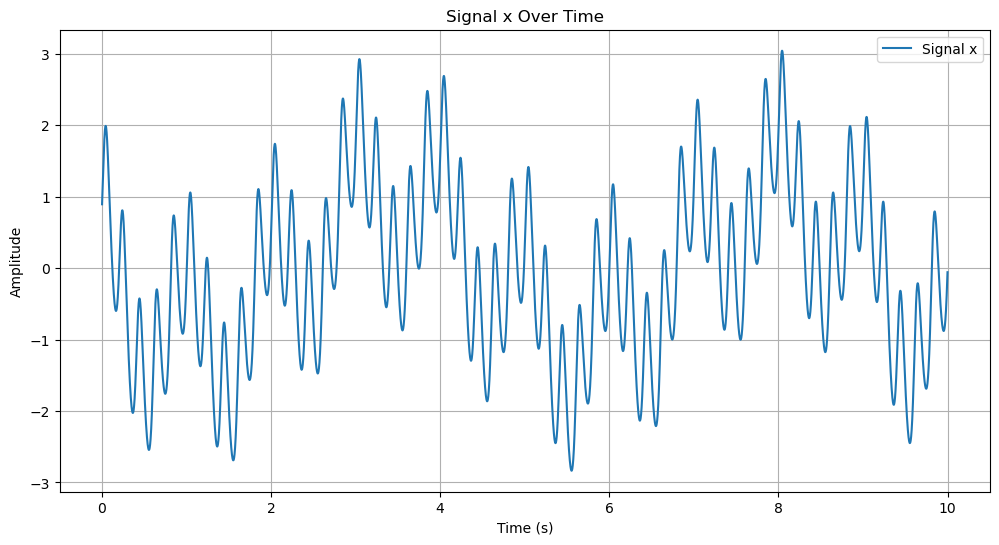

In [16]:
sample_rate = 1000
seconds = 10
num_samples = sample_rate*seconds
time_vect = np.linspace(0, seconds, num_samples)
freq = 5

# Change extent of deformation from sinusoidal shape [-1 to 1]
nonlinearity_deg = .25

# Change left-right skew of deformation [-pi to pi]
nonlinearity_phi = -np.pi/4

# Create a non-linear oscillation
x = emd.simulate.abreu2010(freq, nonlinearity_deg, nonlinearity_phi, sample_rate, seconds)

x += np.cos(2 * np.pi * 1 * time_vect)        # Add a simple 1Hz sinusoid
x -= np.sin(2 * np.pi * 2.2e-1 * time_vect)   # Add a very slow cycle

# sphinx_gallery_thumbnail_number = 7
# Plot the signal
plt.figure(figsize=(12, 6))
plt.plot(time_vect, x, label='Signal x')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Signal x Over Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

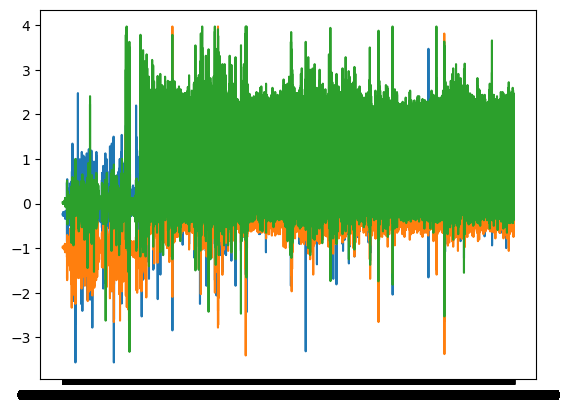

In [24]:
df=pd.read_csv("Filename_selection_split#5_0.txt",sep="\t",index_col='Time')
df1=df.iloc[:,:3]
# Label the columns as 'x', 'y', and 'z'
df1.columns = ['x', 'y', 'z']



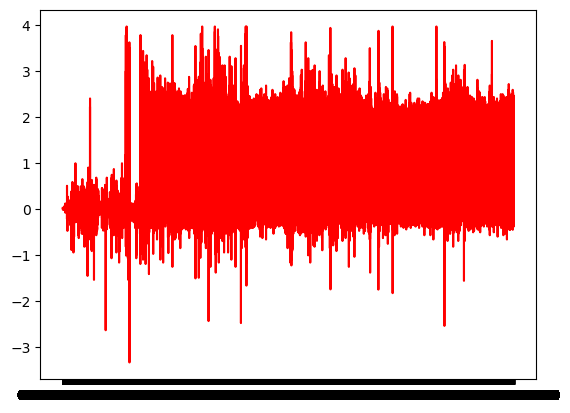

In [25]:
plt.plot(df1.index, df1['z'], label='Z Channel', color='red')
plt.show()

84903


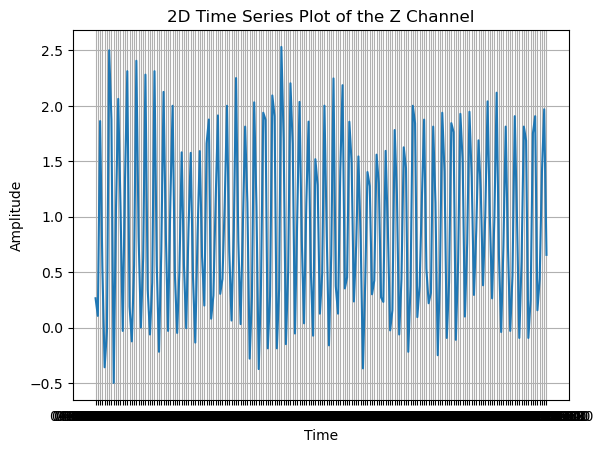

In [33]:
z = df1['z']
print(len(z))
Z = z[51000:51200]

# Plot the 'z' channel with limited data points on the x-axis (from 1 to 1000)
plt.plot(Z.index, Z.values)

# Set labels for the axes
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Set the title
plt.title('2D Time Series Plot of the Z Channel')

# Show the plot
plt.grid(True)
plt.show()

## Sifting



The top-level of options configure the sift itself. These options vary
between the type of sift that is being performed and options don't generalise
between different variants of the sift.

Here we will run a standard sift on our simulation.



<Axes: xlabel='Time (samples)'>

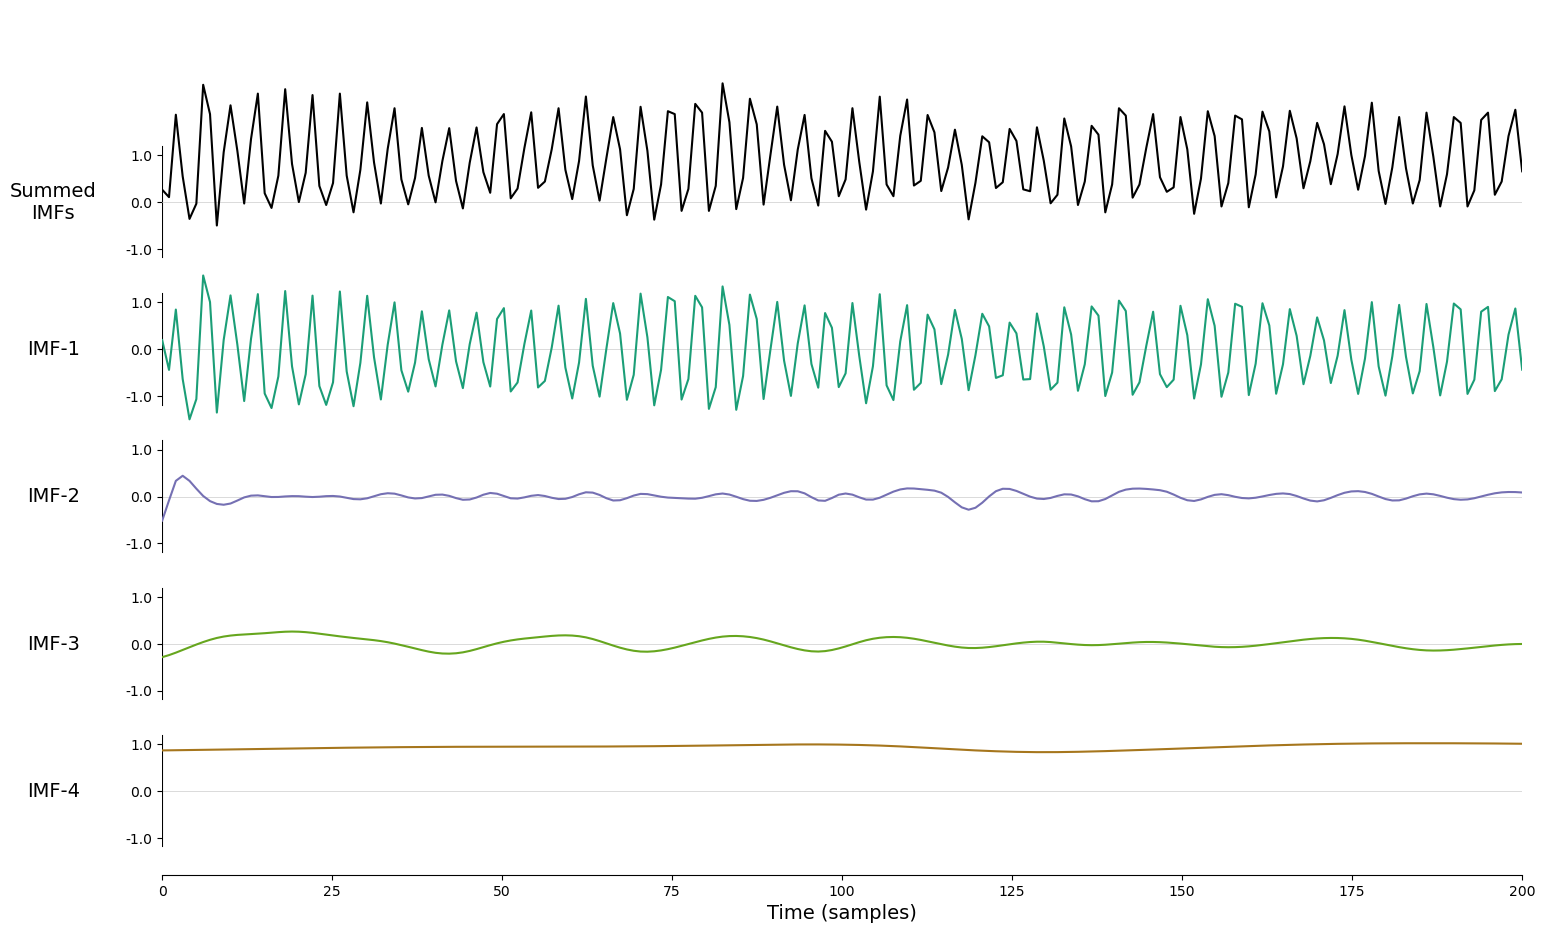

In [35]:
# Convert Z to a NumPy array if it's not already
Z = np.array(Z)

# Ensure Z is one-dimensional
Z = Z.flatten()

# Get the default configuration for a sift
config = emd.sift.get_config('sift')
# Adjust the threshold for accepting an IMF
config['imf_opts/sd_thresh'] = 0.05

imf = emd.sift.sift(Z)

emd.plotting.plot_imfs(imf)

<Axes: xlabel='Time (samples)'>

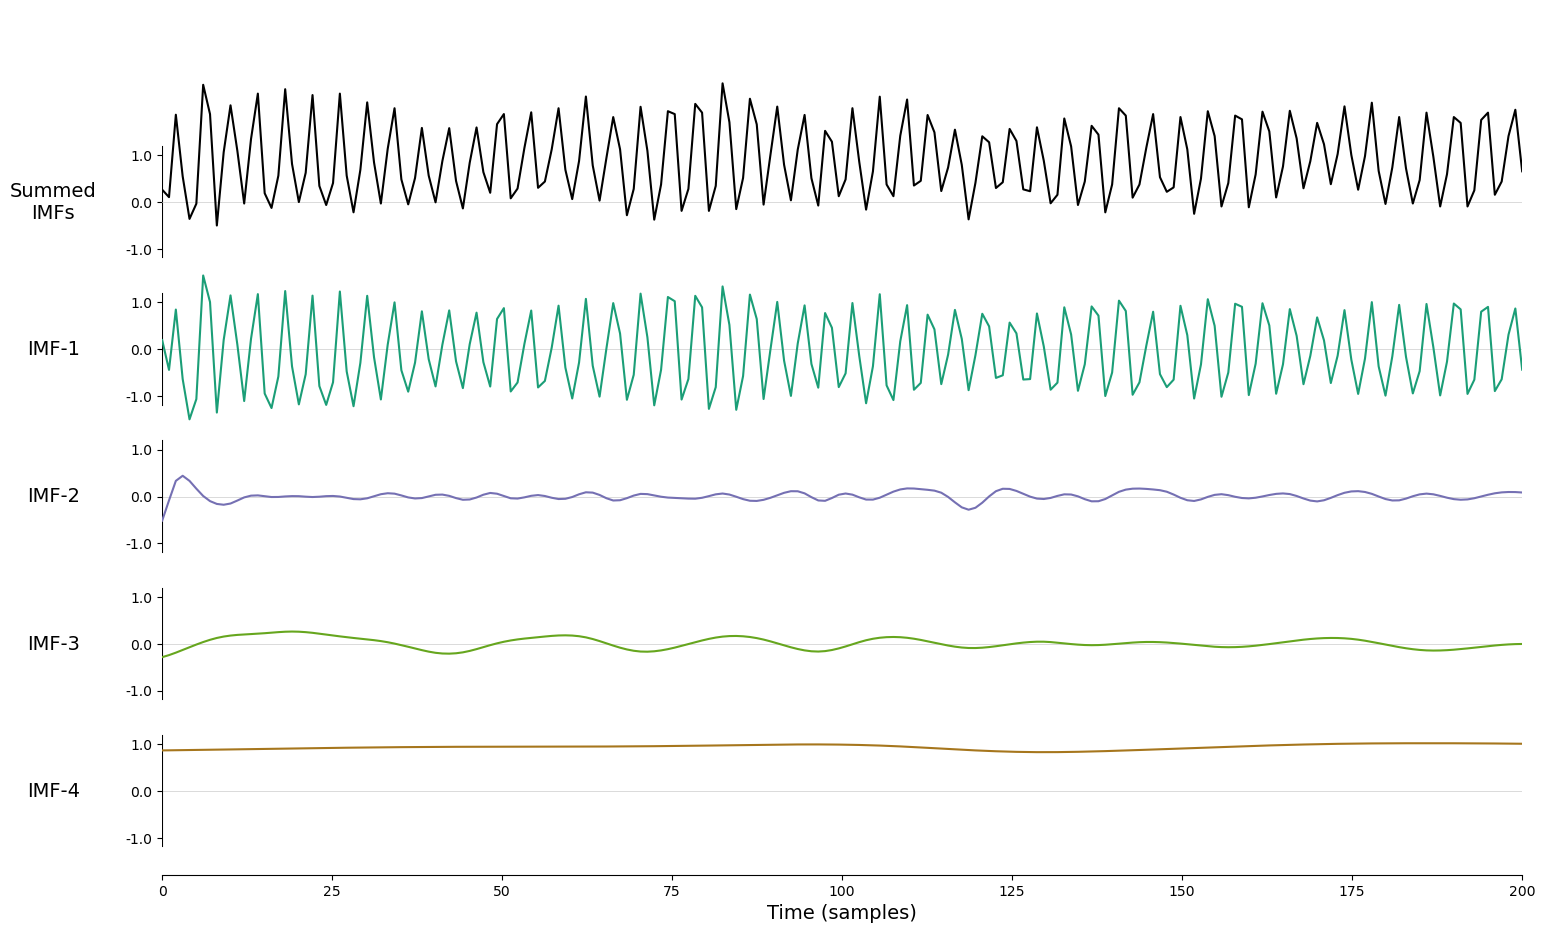

In [36]:
# Get the default configuration for a sift
config = emd.sift.get_config('sift')
# Adjust the threshold for accepting an IMF
config['imf_opts/sd_thresh'] = 0.05
config['extrema_opts/method'] = 'rilling'

imf = emd.sift.sift(Z)

emd.plotting.plot_imfs(imf)

Internally the ``sift`` function calls a set of lower level functions to
 extract the IMFs. These functions are call in a hierarchy when you run
 ``sift`` it will call ``get_next_imf`` behind the scenes. Similarly,
 ``get_next_imf`` makes use of ``interp_envelope`` and so on.

- ``get_next_imf`` extracts the fastest IMF from an input signal
- ``interp_envelope`` find the interpolated envelope of a signal.
- ``get_padded_extrema`` identifies the location and magnitude of signal extrema with optional padding.



We will run through each of these functions in now, giving some examples of their use and options.



## IMF Extraction



After the top-level sift function, the next layer is IMF extraction as
implemented in ``emd.sift.get_next_imf``.  This uses the envelope
interpolation and extrema detection to carry out the sifting iterations on a
time-series to return a single intrinsic mode function.

This is the main function used when implementing novel types of sift. For
instance, the ensemble sift uses this ``emd.sift.get_next_imf`` to extract
IMFs from many repetitions of the signal with small amounts of noise added.
Similarly the mask sift calls ``emd.sift.get_next_imf`` after adding a mask
signal to the data.

Here we call ``get_next_imf`` repeatedly on a signal and its residuals to
implement a very simple sift. We extract the first IMF, subtract it from the
data and then extract the second and third IMFs. We then plot the original
signal, the IMFs and the residual.



<Axes: xlabel='Time (samples)'>

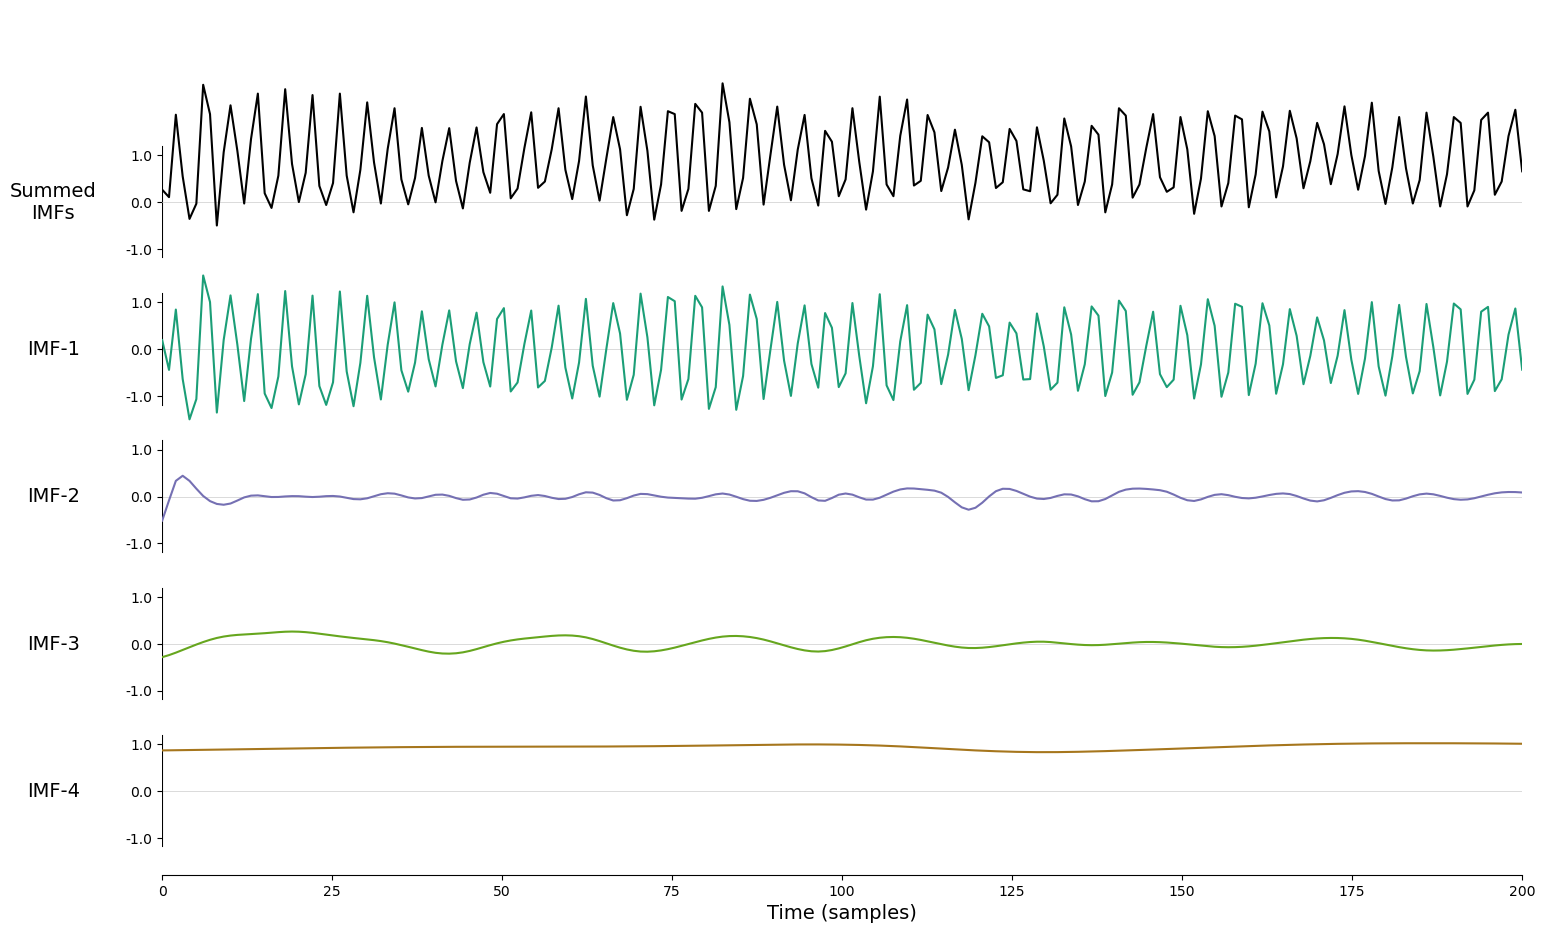

In [38]:
# Extract the options for get_next_imf - these can be customised here at this point.
imf_opts = config['imf_opts']

# Extract first IMF from the signal
imf1, continue_sift = emd.sift.get_next_imf(Z[:, None],           **imf_opts)

# Extract second IMF from the signal with the first IMF removed
imf2, continue_sift = emd.sift.get_next_imf(Z[:, None]-imf1,      **imf_opts)

# Extract third IMF from the signal with the first and second IMFs removed
imf3, continue_sift = emd.sift.get_next_imf(Z[:, None]-imf1-imf2, **imf_opts)

# The residual is the signal component left after removing the IMFs
residual = Z[:, None] - imf1 - imf2 - imf3

# Contactenate our IMFs into one array
imfs_manual = np.c_[imf1, imf2, imf3, residual]

# Visualise
emd.plotting.plot_imfs(imfs_manual)

These IMFs should be identical to the IMFs obtained using ``emd.sift.sift`` above.



## Envelope interpolation



A large part of IMF exraction is the computation of an upper and lower
envelope of the signal.  This is done through interpolation using
``emd.sift.interp_envelope`` and the options in the ``envelope`` section of
the config.




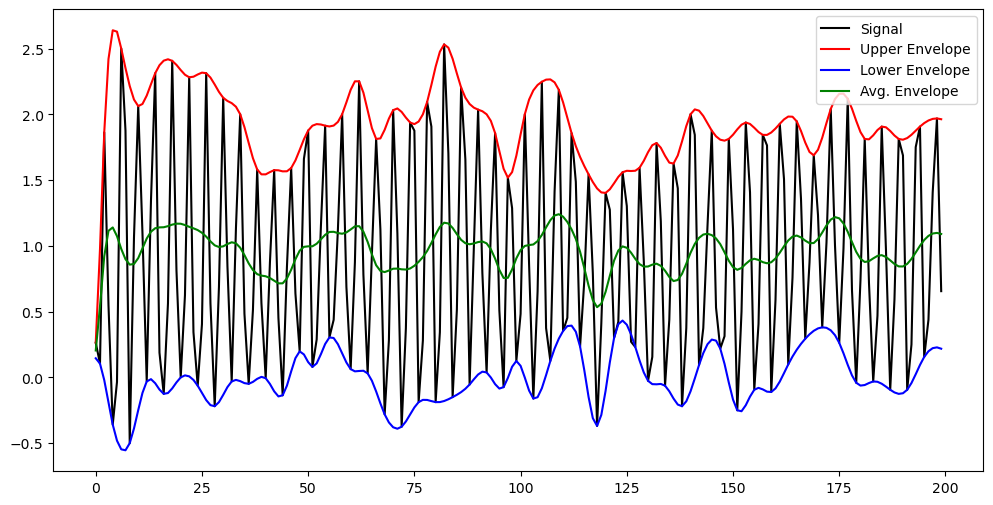

In [39]:
# Extract envelope options
env_opts = config['envelope_opts']

# Compute upper and lower envelopes
upper_env = emd.sift.interp_envelope(Z, mode='upper', **env_opts)
lower_env = emd.sift.interp_envelope(Z, mode='lower', **env_opts)

# Compute average envelope
avg_env = (upper_env+lower_env) / 2

# Visualise
plt.figure(figsize=(12, 6))
plt.plot(Z, 'k')
plt.plot(upper_env, 'r')
plt.plot(lower_env, 'b')
plt.plot(avg_env, 'g')
plt.legend(['Signal', 'Upper Envelope', 'Lower Envelope', 'Avg. Envelope'])

Subtracting the upper and lower envelopes from the signal removes slow
dynamics from the signal. Next, we subtract the average envelope from our
signal.



Text(0.5, 1.0, 'IMF1')

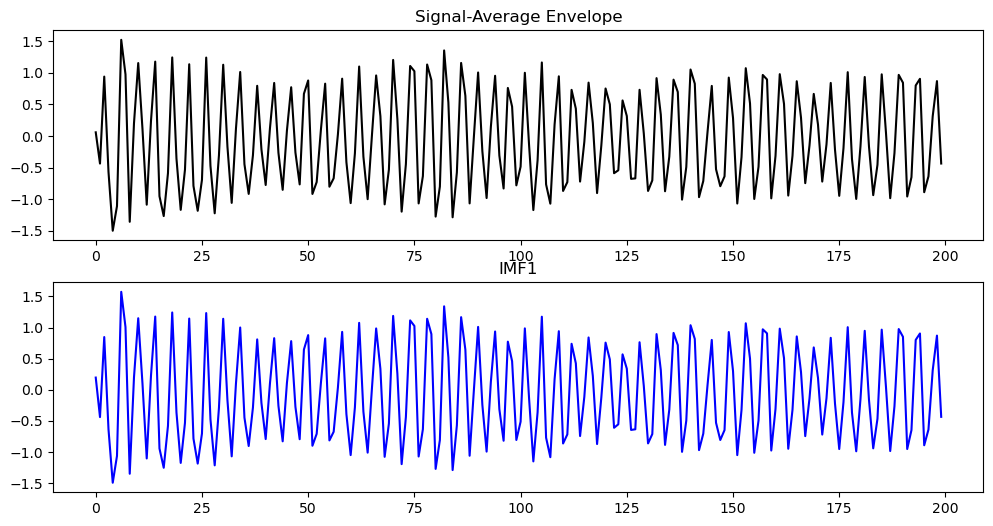

In [40]:
# Plot the signal with the average of the upper and lower envelopes subtracted alongside IMF1
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(Z-avg_env, 'k')
plt.title('Signal-Average Envelope')
plt.subplot(212)
plt.plot(imf1, 'b')
plt.title('IMF1')

Note that the simple subtraction is very similar to IMF1 as extracted above.
In real data, several iterations of envelope computation and subtraction may
be required to identify a well-formed IMF.

In this case there is a small amplitude error in the IMF at the very start.
This is due to uncertainty in the envelope interpolation at the edges. This
can sometimes be reduced by changing the interpolation and extrema padding
options but is hard to completely overcome. It is often sensible to treat the
first and last couple of cycles in an IMF with caution.



## Extrema detection and padding



Finally, the lowest-level functions involve extrema detection and padding as
implemented in the ``emd.sift.get_padded_extrema`` function. This is a simple
function which identifies extrema using ``scipy.signal``. Here we identify
peaks and troughs without any padding applied.



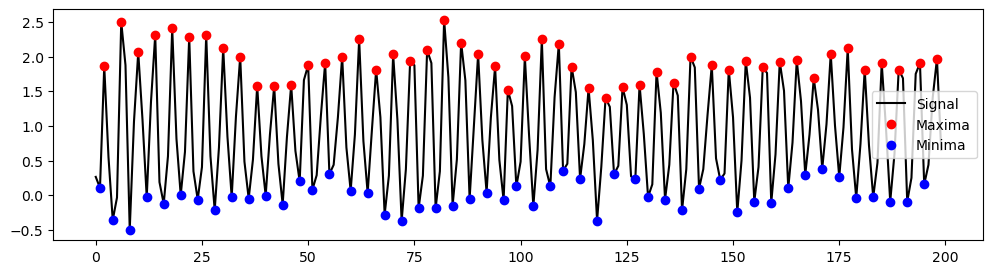

In [41]:
max_locs, max_mag = emd.sift.get_padded_extrema(Z, pad_width=0, mode='peaks')
min_locs, min_mag = emd.sift.get_padded_extrema(Z, pad_width=0, mode='troughs')

plt.figure(figsize=(12, 3))
plt.plot(Z, 'k')
plt.plot(max_locs, max_mag, 'or')
plt.plot(min_locs, min_mag, 'ob')
plt.legend(['Signal', 'Maxima', 'Minima'])

Extrema padding is used to stablise the envelope at the edges of the
time-series. The ``emd.sift.get_padded_extrema`` function identifies and pads
extrema in a time-series. This calls the ``emd.sift.find_extrema`` internally.



Text(0.5, 1.0, 'Rillings Method')

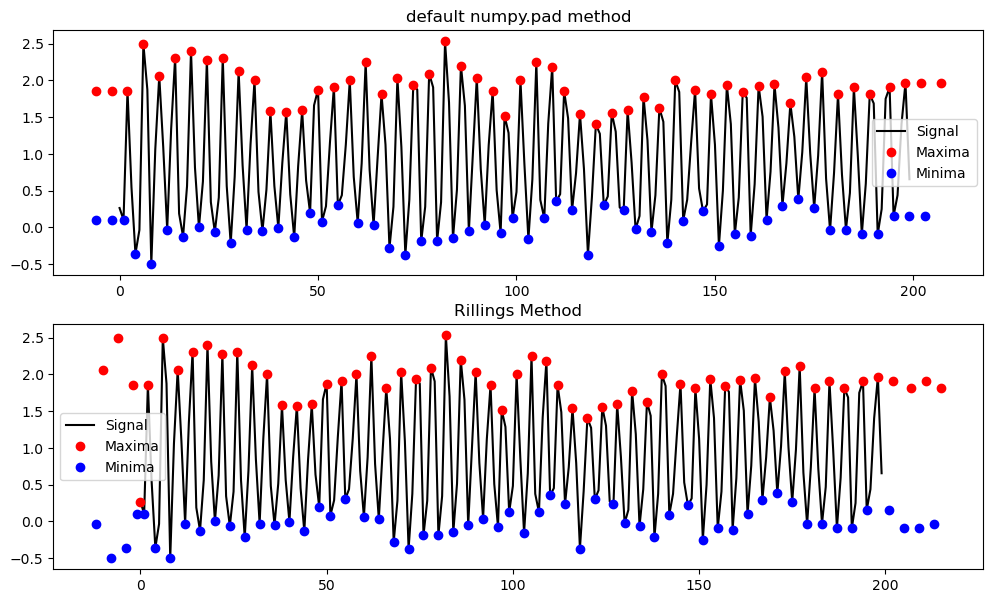

In [42]:
plt.figure(figsize=(12, 7))

# Method 1 - np.pad
max_locs, max_mag = emd.sift.get_padded_extrema(Z, pad_width=2, mode='peaks', method='numpypad')
min_locs, min_mag = emd.sift.get_padded_extrema(Z, pad_width=2, mode='troughs', method='numpypad')

plt.subplot(211)
plt.plot(Z, 'k')
plt.plot(max_locs, max_mag, 'or')
plt.plot(min_locs, min_mag, 'ob')
plt.legend(['Signal', 'Maxima', 'Minima'])
plt.title('default numpy.pad method')

# Method 2 - Rillings method
max_locs, max_mag = emd.sift.get_padded_extrema(Z, pad_width=4, mode='peaks', method='rilling')
min_locs, min_mag = emd.sift.get_padded_extrema(Z, pad_width=4, mode='troughs', method='rilling')

plt.subplot(212)
plt.plot(Z, 'k')
plt.plot(max_locs, max_mag, 'or')
plt.plot(min_locs, min_mag, 'ob')
plt.legend(['Signal', 'Maxima', 'Minima'])
plt.title('Rillings Method')

Extrema padding is used to stablise the envelope at the edges of the
time-series. The ``emd.sift.get_padded_extrema`` function identifies and pads
extrema in a time-series. This calls the ``emd.sift.find_extrema`` internally.



Text(0.5, 1.0, 'Rillings Method')

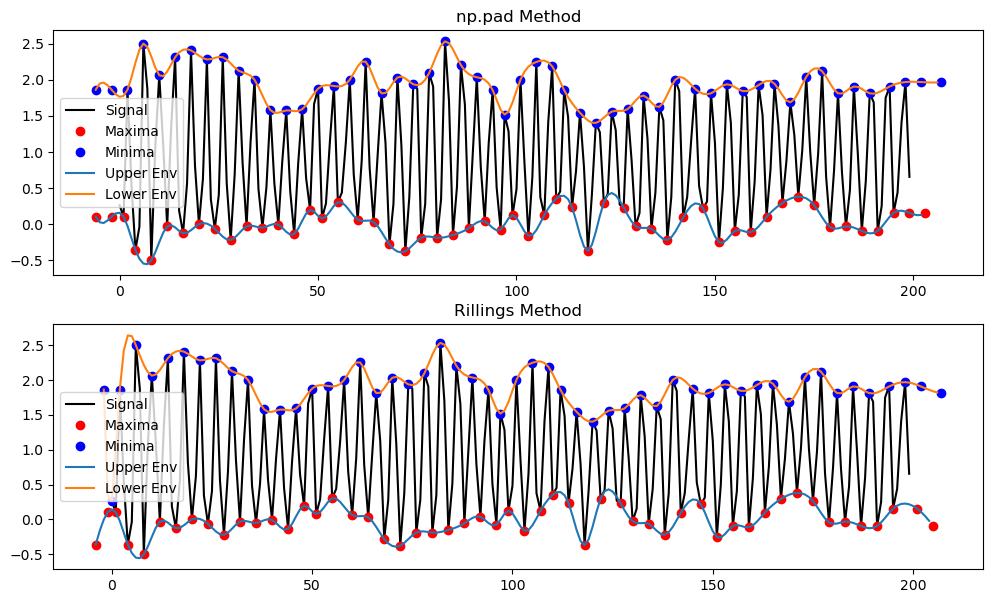

In [43]:
plt.figure(figsize=(12, 7))

env, extr = emd.sift.interp_envelope(Z, ret_extrema=True, extrema_opts={'method': 'numpypad'}, trim=False)
plt.subplot(211)
plt.plot(Z, 'k')
plt.plot(extr[0], extr[1], 'or')
plt.plot(extr[2], extr[3], 'ob')
plt.plot(np.arange(extr[0][0], extr[0][-1]), env[1])
plt.plot(np.arange(extr[2][0], extr[2][-1]), env[0])
plt.legend(['Signal', 'Maxima', 'Minima', 'Upper Env', 'Lower Env'])
plt.title('np.pad Method')

env, extr = emd.sift.interp_envelope(Z, ret_extrema=True, extrema_opts={'method': 'rilling'}, trim=False)
plt.subplot(212)
plt.plot(Z, 'k')
plt.plot(extr[0], extr[1], 'or')
plt.plot(extr[2], extr[3], 'ob')
plt.plot(np.arange(extr[0][0], extr[0][-1]), env[1])
plt.plot(np.arange(extr[2][0], extr[2][-1]), env[0])
plt.legend(['Signal', 'Maxima', 'Minima', 'Upper Env', 'Lower Env'])
plt.title('Rillings Method')

The extrema detection and padding arguments are specified in the config dict
under the extrema, mag_pad and loc_pad keywords. These are passed directly
into ``emd.sift.get_padded_extrema`` when running the sift.

The default extrema padding uses Rilling's method, but we can switch this to
use a built in numpy function ``np.pad``. The ``mag_pad`` and ``loc_pad``
dictionaries are passed into np.pad to define the padding in the y-axis
(extrema magnitude) and x-axis (extrema time-point) respectively. Note that
``np.pad`` takes a mode as a positional argument - this must be included as a
keyword argument here.

Lets try customising the extrema padding. First we get the 'extrema' options
from a nested config then try changing a couple of options



Text(0.5, 1.0, 'Reflected extrema and increased pad width')

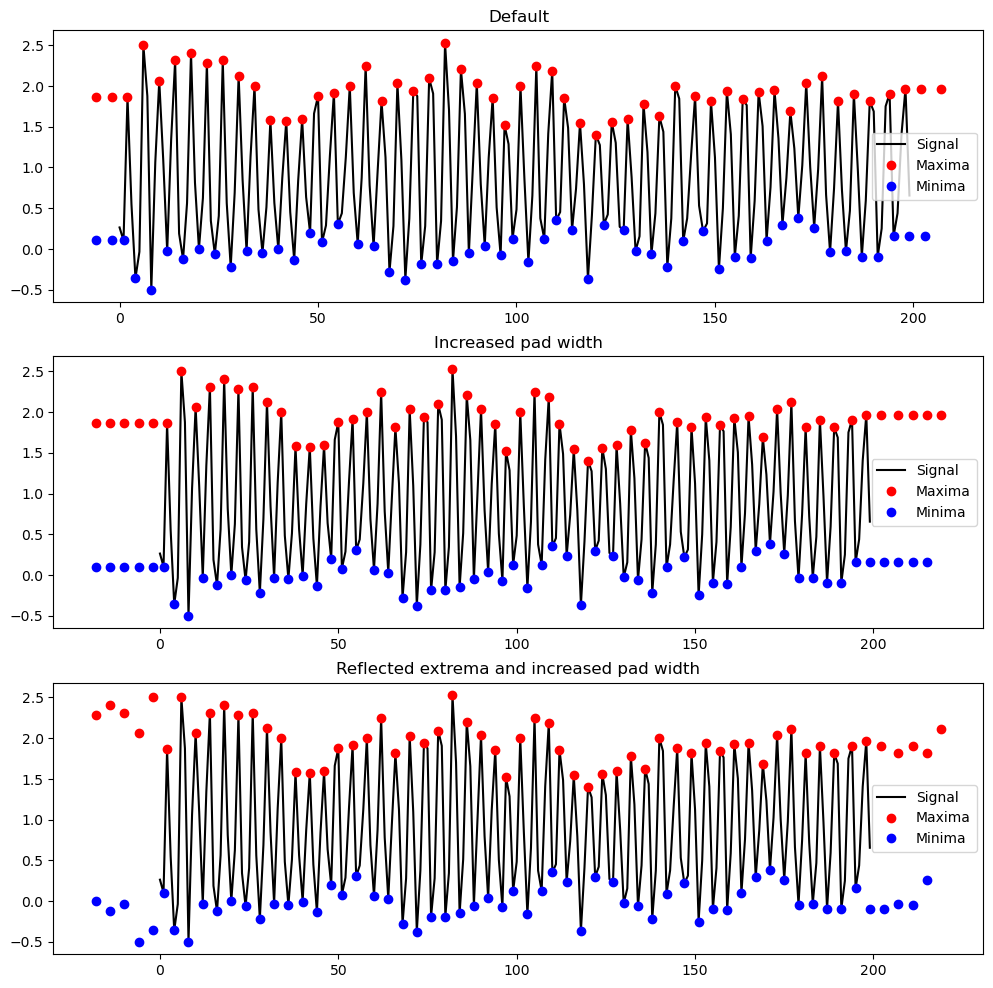

In [44]:
ext_opts = config['extrema_opts']
ext_opts['method'] = 'numpypad'

# The default options
max_locs, max_mag = emd.sift.get_padded_extrema(Z, mode='peaks', **ext_opts)
min_locs, min_mag = emd.sift.get_padded_extrema(Z, mode='troughs', **ext_opts)

plt.figure(figsize=(12, 12))

plt.subplot(311)
plt.plot(Z, 'k')
plt.plot(max_locs, max_mag, 'or')
plt.plot(min_locs, min_mag, 'ob')
plt.legend(['Signal', 'Maxima', 'Minima'])
plt.title('Default')

# Increase the pad width to 5 extrema
ext_opts['pad_width'] = 5
max_locs, max_mag = emd.sift.get_padded_extrema(Z, mode='peaks', **ext_opts)
min_locs, min_mag = emd.sift.get_padded_extrema(Z, mode='troughs', **ext_opts)

plt.subplot(312)
plt.plot(Z, 'k')
plt.plot(max_locs, max_mag, 'or')
plt.plot(min_locs, min_mag, 'ob')
plt.legend(['Signal', 'Maxima', 'Minima'])
plt.title('Increased pad width')

# Change the y-axis padding to 'reflect' rather than 'median' (this option is
# for illustration and not recommended for actual sifting....)
ext_opts['mag_pad_opts']['mode'] = 'reflect'
del ext_opts['mag_pad_opts']['stat_length']
max_locs, max_mag = emd.sift.get_padded_extrema(Z, mode='peaks', **ext_opts)
min_locs, min_mag = emd.sift.get_padded_extrema(Z, mode='troughs', **ext_opts)

plt.subplot(313)
plt.plot(Z, 'k')
plt.plot(max_locs, max_mag, 'or')
plt.plot(min_locs, min_mag, 'ob')
plt.legend(['Signal', 'Maxima', 'Minima'])
plt.title('Reflected extrema and increased pad width')

## Further Reading & References



Huang, N. E., Shen, Z., Long, S. R., Wu, M. C., Shih, H. H., Zheng, Q., … Liu, H. H. (1998).
The empirical mode decomposition and the Hilbert spectrum for nonlinear and
non-stationary time series analysis. Proceedings of the Royal Society of
London. Series A: Mathematical, Physical and Engineering Sciences, 454(1971), 903–995.
https://doi.org/10.1098/rspa.1998.0193

